In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel # AutoModel for base embeddings
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import os
#AdamW

In [29]:
dataset_path = '/kaggle/input/tweepfakemsnew'
df = pd.read_csv(f'{dataset_path}/train.csv', delimiter=';')

# Set plotting style for thesis-quality figures
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

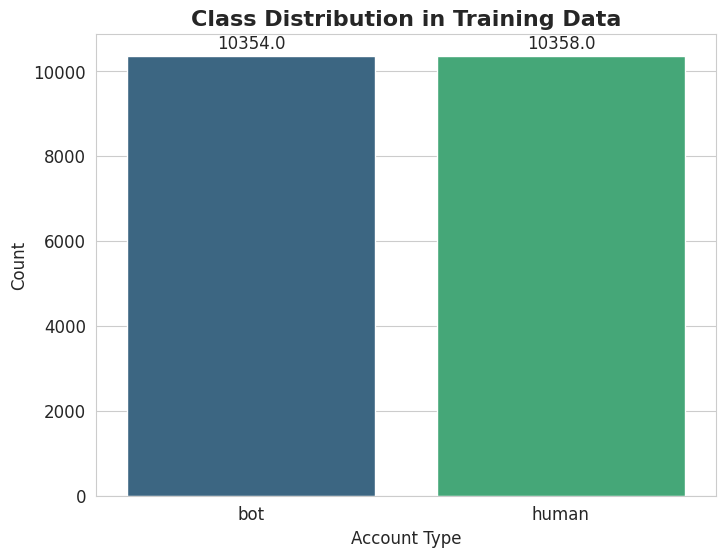

In [30]:
#1b. Class Distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='account.type', data=df, palette='viridis')
ax.set_title('Class Distribution in Training Data', fontsize=16, weight='bold')
ax.set_xlabel('Account Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
#plt.savefig('eda_class_distribution.png')
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


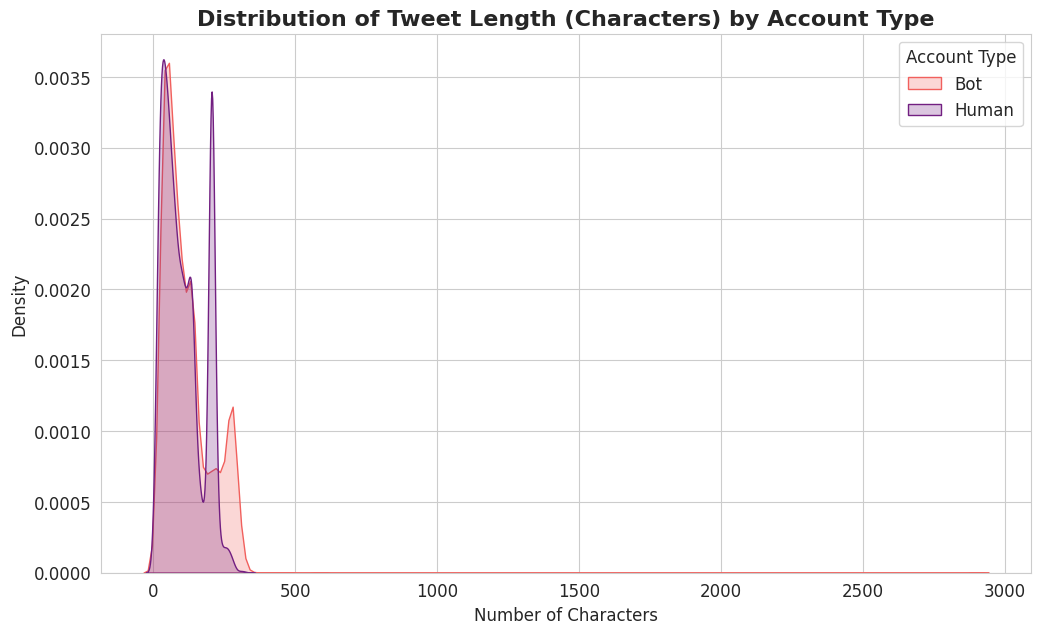

In [31]:
# 1c. Text Length Distribution
df['text_length'] = df['text'].str.len()

plt.figure(figsize=(12, 7))
sns.kdeplot(data=df, x='text_length', hue='account.type', fill=True, palette='magma')
plt.title('Distribution of Tweet Length (Characters) by Account Type', fontsize=16, weight='bold')
plt.xlabel('Number of Characters', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Account Type', labels=['Bot', 'Human'])
plt.savefig('eda_text_length_distribution.png')
plt.show()

In [32]:
df_bots = df[df['account.type'] == 'bot']
df_bots.head()

,screen_name,text,account.type,class_type,text_length
0,imranyebot,YEA now that note GOOD,bot,others,22
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others,57
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others,63
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn,180
6,whalefakes,the world needs more whale stories. I would lo...,bot,gpt2,92


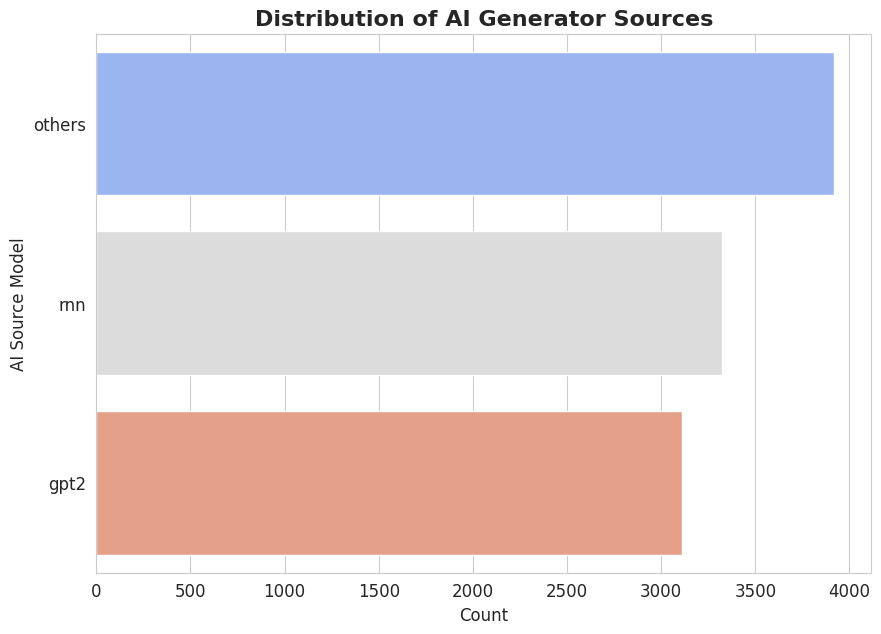

In [33]:
#1d. AI Generator Source Distribution (for Bot accounts)
df_bots = df[df['account.type'] == 'bot']

plt.figure(figsize=(10, 7))
ax = sns.countplot(y='class_type', data=df_bots, order=df_bots['class_type'].value_counts().index, palette='coolwarm')
ax.set_title('Distribution of AI Generator Sources', fontsize=16, weight='bold')
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('AI Source Model', fontsize=12)
#plt.savefig('eda_ai_source_distribution.png')
plt.show()

In [2]:
# --- 0. Configuration & Seeding (Adjust as needed) ---
SEED = 42
ROBERTA_MODEL_NAME = "roberta-base" # Ensure this is consistent
MAX_LEN_ROBERTA = 128
BATCH_SIZE = 16 # Can be smaller for RoBERTa based models
EPOCHS_HYBRID = 5 # Transformers fine-tune faster
LEARNING_RATE_HYBRID = 2e-5
LSTM_HIDDEN_DIM_HYBRID = 128 # Hidden dim for the LSTM layer
LSTM_LAYERS_HYBRID = 1      # Number of LSTM layers
LSTM_DROPOUT_HYBRID = 0.2   # Dropout for LSTM and final layer
OUTPUT_DIR_HYBRID = "./roberta_lstm_hybrid_output"

if not os.path.exists(OUTPUT_DIR_HYBRID):
    os.makedirs(OUTPUT_DIR_HYBRID)

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [3]:
# --- 1. Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# --- 2. Load Data (Assuming df_train_orig, df_val_orig, df_test_orig are loaded) ---
dataset_path = '/kaggle/input/tweepfakemsnew'
df_train_orig = pd.read_csv(f'{dataset_path}/train.csv', delimiter=';')
df_val_orig = pd.read_csv(f'{dataset_path}/validation.csv', delimiter=';')
df_test_orig = pd.read_csv(f'{dataset_path}/test.csv', delimiter=';')

In [5]:
# --- 3. Basic Text Cleaning (Consistent for RoBERTa-based models) ---
def clean_text_for_roberta(text):
    text = str(text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9@#\' ]+', '', text)
    text = text.lower().strip()
    return text

df_train_orig['processed_text'] = df_train_orig['text'].apply(clean_text_for_roberta)
df_val_orig['processed_text'] = df_val_orig['text'].apply(clean_text_for_roberta)
df_test_orig['processed_text'] = df_test_orig['text'].apply(clean_text_for_roberta)

In [6]:
# --- 4. Label Encoding ---
label_mapping = {'human': 0, 'bot': 1}
num_labels_hybrid = len(label_mapping)

df_train_orig['label_encoded'] = df_train_orig['account.type'].map(label_mapping)
df_val_orig['label_encoded'] = df_val_orig['account.type'].map(label_mapping)
df_test_orig['label_encoded'] = df_test_orig['account.type'].map(label_mapping)

In [7]:
# Filter out empty strings AFTER cleaning (if any were created and not handled before)
# This should ideally be done before tokenization
df_train_orig = df_train_orig[df_train_orig['processed_text'].str.strip() != ""].reset_index(drop=True)
df_val_orig = df_val_orig[df_val_orig['processed_text'].str.strip() != ""].reset_index(drop=True)
df_test_orig = df_test_orig[df_test_orig['processed_text'].str.strip() != ""].reset_index(drop=True)


In [8]:
# --- 5. RoBERTa Tokenizer ---
tokenizer_roberta = AutoTokenizer.from_pretrained(ROBERTA_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [9]:
# --- 6. Tokenization Function ---
def tokenize_data_roberta(texts, labels, tokenizer, max_len):
    encodings = tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors="pt"
    )
    return encodings, torch.tensor(labels.values, dtype=torch.long)

train_encodings_hybrid, train_labels_hybrid = tokenize_data_roberta(df_train_orig['processed_text'], df_train_orig['label_encoded'], tokenizer_roberta, MAX_LEN_ROBERTA)
val_encodings_hybrid, val_labels_hybrid = tokenize_data_roberta(df_val_orig['processed_text'], df_val_orig['label_encoded'], tokenizer_roberta, MAX_LEN_ROBERTA)
test_encodings_hybrid, test_labels_hybrid = tokenize_data_roberta(df_test_orig['processed_text'], df_test_orig['label_encoded'], tokenizer_roberta, MAX_LEN_ROBERTA)

In [10]:
# --- 7. Create TensorDatasets and DataLoaders ---
train_dataset_hybrid = TensorDataset(train_encodings_hybrid['input_ids'], train_encodings_hybrid['attention_mask'], train_labels_hybrid)
val_dataset_hybrid = TensorDataset(val_encodings_hybrid['input_ids'], val_encodings_hybrid['attention_mask'], val_labels_hybrid)
test_dataset_hybrid = TensorDataset(test_encodings_hybrid['input_ids'], test_encodings_hybrid['attention_mask'], test_labels_hybrid)

train_dataloader_hybrid = DataLoader(train_dataset_hybrid, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader_hybrid = DataLoader(val_dataset_hybrid, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader_hybrid = DataLoader(test_dataset_hybrid, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
# --- 8. Model Definition: RoBERTa + LSTM Hybrid ---
class RobertaLSTMHybridModel(nn.Module):
    def __init__(self, roberta_model_name, lstm_hidden_dim, lstm_layers, num_classes, dropout_rate, bidirectional_lstm=True):
        super(RobertaLSTMHybridModel, self).__init__()
        self.roberta = AutoModel.from_pretrained(roberta_model_name)
        roberta_output_dim = self.roberta.config.hidden_size
        self.bidirectional_lstm = bidirectional_lstm

        self.lstm = nn.LSTM(
            input_size=roberta_output_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout_rate if lstm_layers > 1 else 0,
            bidirectional=self.bidirectional_lstm
        )
        
        classifier_input_dim = lstm_hidden_dim * 2 if self.bidirectional_lstm else lstm_hidden_dim
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(classifier_input_dim, num_classes)

    def forward(self, input_ids, attention_mask, labels=None): # labels for potential internal loss calc
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        # last_hidden_state shape: (batch_size, sequence_length, roberta_hidden_size)
        sequence_output = roberta_outputs.last_hidden_state

        # LSTM processing
        # lstm_output shape: (batch_size, sequence_length, lstm_hidden_dim * num_directions)
        # hidden shape: (num_layers * num_directions, batch_size, lstm_hidden_dim)
        # cell shape: (num_layers * num_directions, batch_size, lstm_hidden_dim)
        lstm_output, (hidden, cell) = self.lstm(sequence_output)

        # We'll use the final hidden state(s) of the LSTM for classification
        if self.bidirectional_lstm:
            # Concatenate the final hidden states from both directions from the last LSTM layer
            # hidden is stacked as [forward_layer_0, backward_layer_0, forward_layer_1, backward_layer_1, ...]
            # For a single layer bidirectional LSTM (lstm_layers=1):
            # hidden[-2,:,:] is the last forward hidden state
            # hidden[-1,:,:] is the last backward hidden state
            # For multi-layer, hidden[-2*n : -2*(n-1)] and hidden[-2*(n-1) : ] might be needed
            # Simpler for num_layers=1:
            # hidden_fwd = hidden[0,:,:] # if layers=1, directions=2, then hidden is (2, B, H)
            # hidden_bwd = hidden[1,:,:]
            # combined_hidden = torch.cat((hidden_fwd, hidden_bwd), dim=1)
            # General way for last layer:
            combined_hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            combined_hidden = hidden[-1,:,:] # Only the last hidden state of the last layer

        dropped_output = self.dropout(combined_hidden)
        logits = self.classifier(dropped_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
            return {"loss": loss, "logits": logits} # Return dict

        return {"logits": logits} # Return dict

In [12]:
model_roberta_lstm = RobertaLSTMHybridModel(
    roberta_model_name=ROBERTA_MODEL_NAME,
    lstm_hidden_dim=LSTM_HIDDEN_DIM_HYBRID,
    lstm_layers=LSTM_LAYERS_HYBRID,
    num_classes=num_labels_hybrid,
    dropout_rate=LSTM_DROPOUT_HYBRID,
    bidirectional_lstm=True # Often performs better
).to(device)

2025-06-09 00:32:11.871354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749429132.068698      75 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749429132.126610      75 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from torch.optim import AdamW

In [14]:
# --- 9. Optimizer & Criterion ---
optimizer_roberta_lstm = AdamW(model_roberta_lstm.parameters(), lr=LEARNING_RATE_HYBRID)
criterion_roberta_lstm = nn.CrossEntropyLoss() # Loss calculated in the model if labels are passed

In [15]:
# --- 10. Training Loop (Generic, ensure it matches your setup) ---
def train_model_generic(model, train_loader, val_loader, optimizer, device, epochs, model_save_path_base, experiment_name_suffix=""):
    criterion = nn.CrossEntropyLoss() # Fallback if model doesn't compute loss
    best_val_f1 = 0.0
    best_model_path = ""
    history = {'epoch': [], 'train_avg_loss': [], 'val_avg_loss': [], 'val_f1_score': [], 'val_accuracy': []}


    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [{experiment_name_suffix} Train]", leave=False)

        for batch in train_progress_bar:
            optimizer.zero_grad()
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels) # Pass labels
            
            if isinstance(outputs, dict) and "loss" in outputs and outputs["loss"] is not None:
                loss = outputs["loss"]
            else: # Fallback if model only returns logits
                logits = outputs["logits"] if isinstance(outputs, dict) else outputs 
                loss = criterion(logits, labels)
            
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            train_progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch + 1} - {experiment_name_suffix} Train Avg Loss: {avg_train_loss:.4f}")

        val_accuracy, val_f1, avg_val_loss = evaluate_model_generic(model, val_loader, device, f"{experiment_name_suffix} Validation")
        
        history['epoch'].append(epoch + 1)
        history['train_avg_loss'].append(avg_train_loss)
        history['val_avg_loss'].append(avg_val_loss)
        history['val_f1_score'].append(val_f1)
        history['val_accuracy'].append(val_accuracy)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            current_model_save_path = os.path.join(OUTPUT_DIR_HYBRID, f"{model_save_path_base}_epoch{epoch+1}_f1_{val_f1:.4f}.pt")
            torch.save(model.state_dict(), current_model_save_path)
            best_model_path = current_model_save_path # Update best model path
            print(f"New best F1: {best_val_f1:.4f}. Model saved to {best_model_path}")

    print(f"Training complete for {experiment_name_suffix}. Best validation F1: {best_val_f1:.4f} from {best_model_path}")
    history_df = pd.DataFrame(history)
    return best_model_path, history_df

In [16]:
# --- 11. Evaluation Function (Generic) ---
def evaluate_model_generic(model, dataloader, device, dataset_name="Dataset"):
    criterion = nn.CrossEntropyLoss() # Fallback for loss calculation
    model.eval()
    all_preds = []
    all_labels = []
    total_eval_loss = 0

    with torch.no_grad():
        eval_progress_bar = tqdm(dataloader, desc=f"Evaluating on {dataset_name}", leave=False)
        for batch in eval_progress_bar:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels) # Pass labels for eval loss too
            
            if isinstance(outputs, dict) and "loss" in outputs and outputs["loss"] is not None:
                loss = outputs["loss"]
                logits = outputs["logits"]
            else: # Fallback if model only returns logits
                logits = outputs["logits"] if isinstance(outputs, dict) else outputs
                loss = criterion(logits, labels)

            total_eval_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_eval_loss = total_eval_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"\n--- {dataset_name} Results ---")
    print(f"Avg Loss: {avg_eval_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print(classification_report(all_labels, all_preds, target_names=list(label_mapping.keys())))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(f'{dataset_name} Confusion Matrix'); plt.show()
    return accuracy, f1, avg_eval_loss



--- Starting Experiment 3: RoBERTa + LSTM Hybrid ---


Epoch 1/5 [RoBERTa-LSTM Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 1 - RoBERTa-LSTM Train Avg Loss: 0.4089


Evaluating on RoBERTa-LSTM Validation:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-LSTM Validation Results ---
Avg Loss: 0.3511
Accuracy: 0.8309
F1-Score (Weighted): 0.8298
              precision    recall  f1-score   support

       human       0.78      0.91      0.84      1143
         bot       0.90      0.75      0.82      1152

    accuracy                           0.83      2295
   macro avg       0.84      0.83      0.83      2295
weighted avg       0.84      0.83      0.83      2295



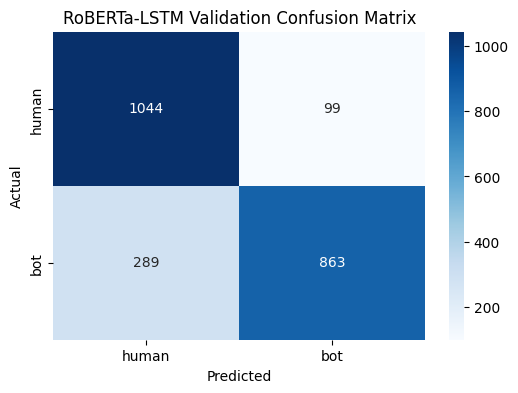

New best F1: 0.8298. Model saved to ./roberta_lstm_hybrid_output/roberta_lstm_hybrid_epoch1_f1_0.8298.pt


Epoch 2/5 [RoBERTa-LSTM Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 2 - RoBERTa-LSTM Train Avg Loss: 0.2759


Evaluating on RoBERTa-LSTM Validation:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-LSTM Validation Results ---
Avg Loss: 0.3337
Accuracy: 0.8444
F1-Score (Weighted): 0.8441
              precision    recall  f1-score   support

       human       0.81      0.90      0.85      1143
         bot       0.88      0.79      0.84      1152

    accuracy                           0.84      2295
   macro avg       0.85      0.84      0.84      2295
weighted avg       0.85      0.84      0.84      2295



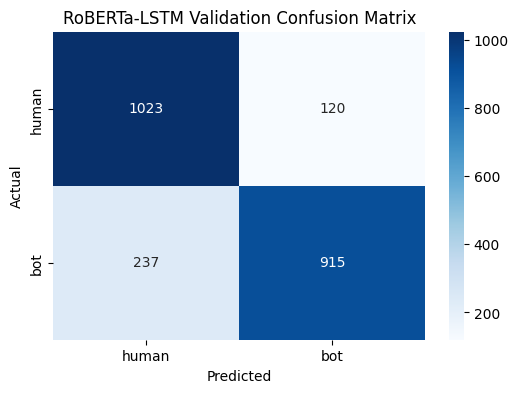

New best F1: 0.8441. Model saved to ./roberta_lstm_hybrid_output/roberta_lstm_hybrid_epoch2_f1_0.8441.pt


Epoch 3/5 [RoBERTa-LSTM Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 3 - RoBERTa-LSTM Train Avg Loss: 0.1921


Evaluating on RoBERTa-LSTM Validation:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-LSTM Validation Results ---
Avg Loss: 0.3705
Accuracy: 0.8505
F1-Score (Weighted): 0.8503
              precision    recall  f1-score   support

       human       0.82      0.89      0.86      1143
         bot       0.88      0.81      0.84      1152

    accuracy                           0.85      2295
   macro avg       0.85      0.85      0.85      2295
weighted avg       0.85      0.85      0.85      2295



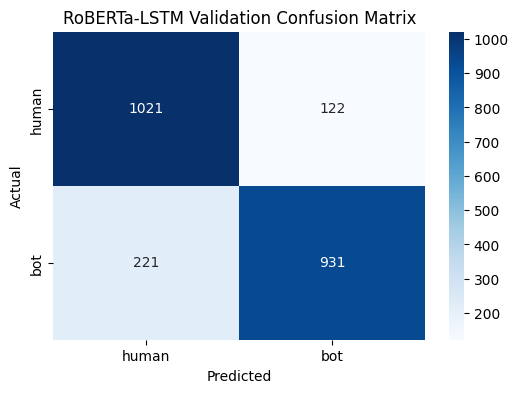

New best F1: 0.8503. Model saved to ./roberta_lstm_hybrid_output/roberta_lstm_hybrid_epoch3_f1_0.8503.pt


Epoch 4/5 [RoBERTa-LSTM Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 4 - RoBERTa-LSTM Train Avg Loss: 0.1250


Evaluating on RoBERTa-LSTM Validation:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-LSTM Validation Results ---
Avg Loss: 0.4214
Accuracy: 0.8527
F1-Score (Weighted): 0.8526
              precision    recall  f1-score   support

       human       0.83      0.89      0.86      1143
         bot       0.88      0.82      0.85      1152

    accuracy                           0.85      2295
   macro avg       0.85      0.85      0.85      2295
weighted avg       0.85      0.85      0.85      2295



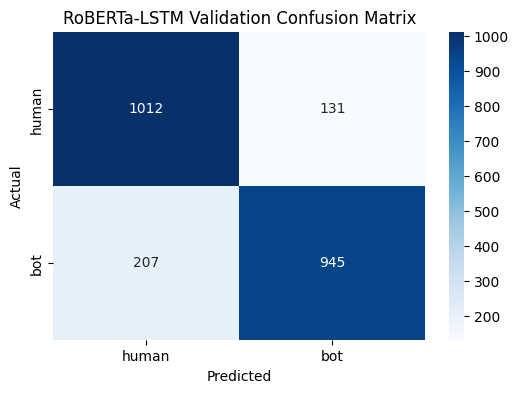

New best F1: 0.8526. Model saved to ./roberta_lstm_hybrid_output/roberta_lstm_hybrid_epoch4_f1_0.8526.pt


Epoch 5/5 [RoBERTa-LSTM Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 5 - RoBERTa-LSTM Train Avg Loss: 0.0797


Evaluating on RoBERTa-LSTM Validation:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-LSTM Validation Results ---
Avg Loss: 0.4966
Accuracy: 0.8423
F1-Score (Weighted): 0.8417
              precision    recall  f1-score   support

       human       0.80      0.90      0.85      1143
         bot       0.89      0.78      0.83      1152

    accuracy                           0.84      2295
   macro avg       0.85      0.84      0.84      2295
weighted avg       0.85      0.84      0.84      2295



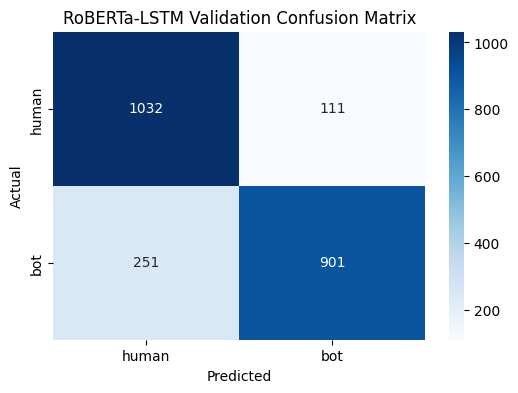

Training complete for RoBERTa-LSTM. Best validation F1: 0.8526 from ./roberta_lstm_hybrid_output/roberta_lstm_hybrid_epoch4_f1_0.8526.pt

Hybrid Training History:
   epoch  train_avg_loss  val_avg_loss  val_f1_score  val_accuracy
0      1        0.408881      0.351051      0.829826      0.830937
1      2        0.275900      0.333719      0.844070      0.844444
2      3        0.192095      0.370485      0.850291      0.850545
3      4        0.125001      0.421357      0.852581      0.852723
4      5        0.079703      0.496588      0.841715      0.842266

Loading best RoBERTa-LSTM Hybrid model from: ./roberta_lstm_hybrid_output/roberta_lstm_hybrid_epoch4_f1_0.8526.pt

--- Testing RoBERTa-LSTM Hybrid on Test Set (with best model) ---


Evaluating on RoBERTa-LSTM Test:   0%|          | 0/160 [00:00<?, ?it/s]


--- RoBERTa-LSTM Test Results ---
Avg Loss: 0.4334
Accuracy: 0.8502
F1-Score (Weighted): 0.8500
              precision    recall  f1-score   support

       human       0.82      0.89      0.86      1270
         bot       0.88      0.81      0.84      1280

    accuracy                           0.85      2550
   macro avg       0.85      0.85      0.85      2550
weighted avg       0.85      0.85      0.85      2550



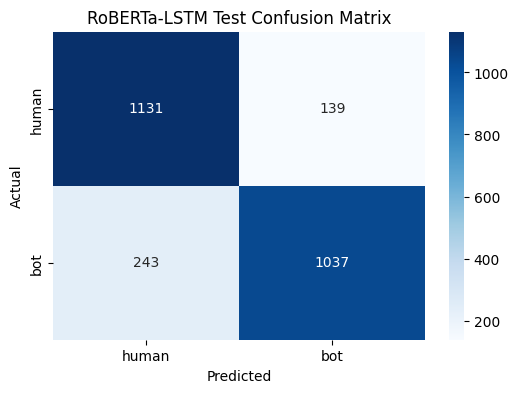

RoBERTa-LSTM Test Set - Accuracy: 0.8502, F1: 0.8500, Loss: 0.4334


In [17]:
# --- 12. Run RoBERTa + LSTM Hybrid Experiment ---
print("\n\n--- Starting Experiment 3: RoBERTa + LSTM Hybrid ---")

best_hybrid_model_path, hybrid_training_history_df = train_model_generic(
    model_roberta_lstm,
    train_dataloader_hybrid,
    val_dataloader_hybrid,
    optimizer_roberta_lstm,
    device,
    epochs=EPOCHS_HYBRID,
    model_save_path_base="roberta_lstm_hybrid",
    experiment_name_suffix="RoBERTa-LSTM"
)

print("\nHybrid Training History:")
print(hybrid_training_history_df)
# Plot history (copy plotting code from previous response if needed)
# ...

# Load the best model for testing
if best_hybrid_model_path and os.path.exists(best_hybrid_model_path):
    print(f"\nLoading best RoBERTa-LSTM Hybrid model from: {best_hybrid_model_path}")
    model_roberta_lstm.load_state_dict(torch.load(best_hybrid_model_path))
else:
    print("No best model for RoBERTa-LSTM Hybrid was saved or path invalid. Evaluating with the last state.")

print("\n--- Testing RoBERTa-LSTM Hybrid on Test Set (with best model) ---")
test_acc_hybrid, test_f1_hybrid, test_loss_hybrid = evaluate_model_generic(
    model_roberta_lstm,
    test_dataloader_hybrid,
    device,
    "RoBERTa-LSTM Test"
)
print(f"RoBERTa-LSTM Test Set - Accuracy: {test_acc_hybrid:.4f}, F1: {test_f1_hybrid:.4f}, Loss: {test_loss_hybrid:.4f}")


Hybrid Training History DataFrame:
   epoch  train_avg_loss  val_avg_loss  val_f1_score  val_accuracy
0      1        0.408881      0.351051      0.829826      0.830937
1      2        0.275900      0.333719      0.844070      0.844444
2      3        0.192095      0.370485      0.850291      0.850545
3      4        0.125001      0.421357      0.852581      0.852723
4      5        0.079703      0.496588      0.841715      0.842266


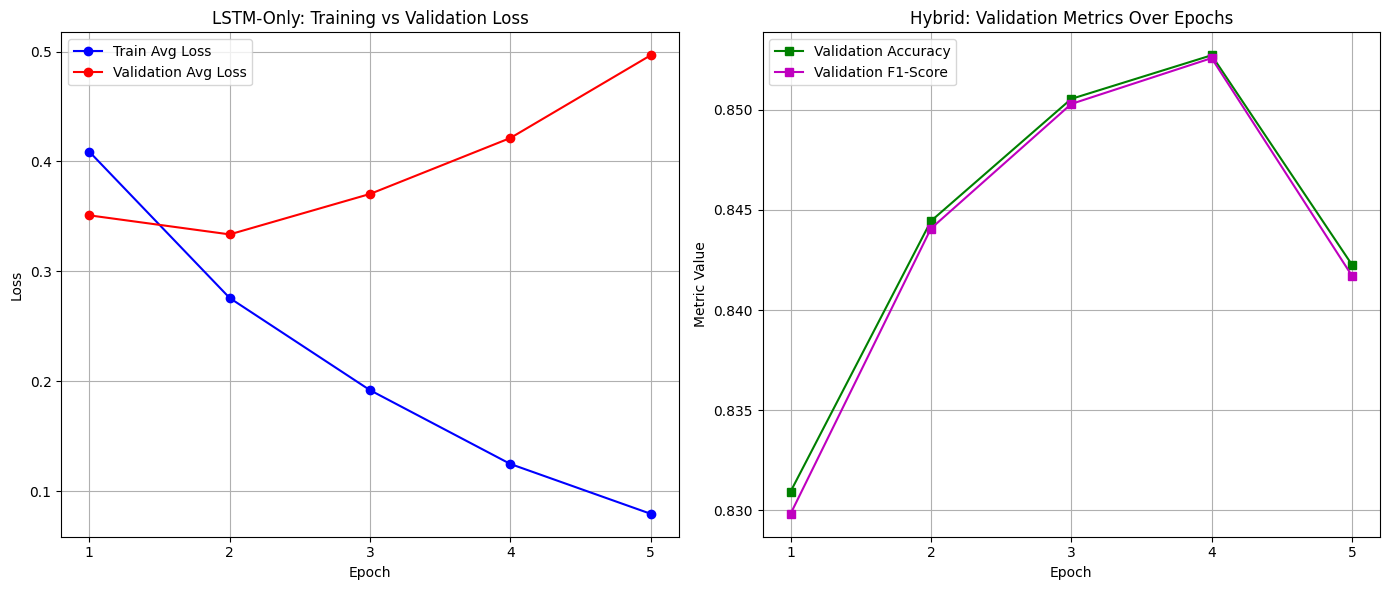

In [20]:
print("\nHybrid Training History DataFrame:")
print(hybrid_training_history_df)

# And to generate the plots (which are very helpful for seeing overfitting):
import matplotlib.pyplot as plt
import pandas as pd # Should already be imported, but good practice

if 'hybrid_training_history_df' in locals() and isinstance(hybrid_training_history_df, pd.DataFrame):
    plt.figure(figsize=(14, 6))

    # Plotting Training vs Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(hybrid_training_history_df['epoch'], hybrid_training_history_df['train_avg_loss'], 'bo-', label='Train Avg Loss')
    plt.plot(hybrid_training_history_df['epoch'], hybrid_training_history_df['val_avg_loss'], 'ro-', label='Validation Avg Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('LSTM-Only: Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    # Ensure all epoch numbers are shown as ticks if there aren't too many
    if len(hybrid_training_history_df['epoch']) <= 20 : # Adjust threshold as needed
        plt.xticks(hybrid_training_history_df['epoch'])


    # Plotting Validation Metrics
    plt.subplot(1, 2, 2)
    plt.plot(hybrid_training_history_df['epoch'], hybrid_training_history_df['val_accuracy'], 'gs-', label='Validation Accuracy')
    plt.plot(hybrid_training_history_df['epoch'], hybrid_training_history_df['val_f1_score'], 'ms-', label='Validation F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('Hybrid: Validation Metrics Over Epochs')
    plt.legend()
    plt.grid(True)
    if len(hybrid_training_history_df['epoch']) <= 20 : # Adjust threshold as needed
        plt.xticks(hybrid_training_history_df['epoch'])


    plt.tight_layout()
    plt.show()
else:
    print("DataFrame 'lstm_training_history_df' not found or is not a DataFrame.")
    print("Please ensure the training cell that defines it has completed successfully.")

In [21]:
# --- SECTION: Post-Training Analysis for RoBERTa-LSTM Hybrid ---
# !pip install lime

import torch
import joblib
import os

# --- 1. Save the tokenizer object ---
# The 'tokenizer_roberta' variable is already in memory from earlier in the notebook.
tokenizer_save_path = os.path.join(OUTPUT_DIR_HYBRID, "tokenizer")
print(f"Saving RoBERTa tokenizer to: {tokenizer_save_path}")
tokenizer_roberta.save_pretrained(tokenizer_save_path)


# --- 2. Load the Best Model ---
# The best model path is already stored in the 'best_hybrid_model_path' variable.
if 'best_hybrid_model_path' in locals() and best_hybrid_model_path and os.path.exists(best_hybrid_model_path):
    print(f"Loading best model from: {best_hybrid_model_path}")
    # Re-instantiate the model architecture. Use variables from the notebook's config.
    loaded_model_ro_lstm = RobertaLSTMHybridModel(
        roberta_model_name=ROBERTA_MODEL_NAME,
        lstm_hidden_dim=LSTM_HIDDEN_DIM_HYBRID,
        lstm_layers=LSTM_LAYERS_HYBRID,
        num_classes=num_labels_hybrid,
        dropout_rate=LSTM_DROPOUT_HYBRID,
        bidirectional_lstm=True
    )
    # Load the saved weights
    loaded_model_ro_lstm.load_state_dict(torch.load(best_hybrid_model_path))
    loaded_model_ro_lstm.to(device)
    loaded_model_ro_lstm.eval()
    print("Best RoBERTa-LSTM model loaded successfully for XAI.")
else:
    print("Could not find a saved model file. Using the model currently in memory.")
    loaded_model_ro_lstm = model_roberta_lstm # Fallback to the model in memory
    loaded_model_ro_lstm.eval()

Saving RoBERTa tokenizer to: ./roberta_lstm_hybrid_output/tokenizer
Loading best model from: ./roberta_lstm_hybrid_output/roberta_lstm_hybrid_epoch4_f1_0.8526.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best RoBERTa-LSTM model loaded successfully for XAI.


In [ ]:
# --- LIME Implementation for RoBERTa-LSTM ---
import lime
import lime.lime_text
import torch.nn.functional as F

# Create a predictor function that LIME can use
def lime_predictor_ro_lstm(texts):
    loaded_model_ro_lstm.eval()
    
    # Use the tokenizer from your notebook: 'tokenizer_roberta'
    inputs = tokenizer_roberta(
        texts, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=MAX_LEN_ROBERTA
    ).to(device)
    
    with torch.no_grad():
        # Your model returns a dictionary, so access the 'logits' key
        logits = loaded_model_ro_lstm(**inputs)["logits"]
        probs = F.softmax(logits, dim=1).cpu().numpy()
        
    return probs

# Create the LIME explainer
explainer_lime_ro_lstm = lime.lime_text.LimeTextExplainer(class_names=['human', 'bot'])

# Explain the same examples for direct comparison
text_to_explain_bot = "new post on my blog check it out now #tech #AI #update"
text_to_explain_human = "Just had the most amazing coffee at this little cafe downtown. So cozy!"

print("--- LIME Explanation for RoBERTa-LSTM on a BOT-like tweet ---")
explanation_bot_ro_lstm = explainer_lime_ro_lstm.explain_instance(text_to_explain_bot, lime_predictor_ro_lstm, num_features=10, labels=(1,))
explanation_bot_ro_lstm.save_to_file(os.path.join(OUTPUT_DIR_HYBRID, 'lime_ro_lstm_bot.html'))
explanation_bot_ro_lstm.show_in_notebook(text=True)

print("\n--- LIME Explanation for RoBERTa-LSTM on a HUMAN-like tweet ---")
explanation_human_ro_lstm = explainer_lime_ro_lstm.explain_instance(text_to_explain_human, lime_predictor_ro_lstm, num_features=10, labels=(0,))
explanation_human_ro_lstm.save_to_file(os.path.join(OUTPUT_DIR_HYBRID, 'lime_ro_lstm_human.html'))
explanation_human_ro_lstm.show_in_notebook(text=True)

--- LIME Explanation for RoBERTa-LSTM on a BOT-like tweet ---



--- LIME Explanation for RoBERTa-LSTM on a HUMAN-like tweet ---


**Analysis of the LIME Outputs for RoBERTa-LSTM**
**Case Study 1:**
Explaining the BOT-like Tweet
Tweet: new post on my blog check it out now #tech #AI #update
Model's Prediction: The model predicted "human" with a very high probability of 99%.
Top Words Influencing the Prediction (towards "human"): new, blog, check, now, AI.
**Interpretation:**
This is a high-confidence misclassification (a False Negative). This result is extremely valuable for your thesis because it showcases a specific weakness.
**The "Why":** The model has overwhelmingly decided this tweet is human. The LIME output shows that the model has learned to associate words like new, blog, and check with human language. Most strikingly, even the strong keywords #tech and #AI are highlighted in green, meaning they contributed to the (incorrect) "human" prediction.
Comparison Point: This is a critical point of contrast with your best RoBERTa+CNN+Extra Features model. That model, with its handcrafted features, would likely have a feature like num_hashtags or word_count that would help it correctly identify this as a bot. The RoBERTa-LSTM, relying only on the text sequence, has been "tricked" by a pattern that might look like a human announcing something. The LSTM head has not learned to correctly weigh the promotional context.

Sampling a smaller subset of data for SHAP analysis to manage memory...


Getting RoBERTa [CLS] Embeddings:   0%|          | 0/10 [00:00<?, ?it/s]

Getting RoBERTa [CLS] Embeddings:   0%|          | 0/5 [00:00<?, ?it/s]

Background data shape: (10, 768)
Explanation data shape: (5, 768)

Calculating SHAP values... (this may still take some time)


  0%|          | 0/5 [00:00<?, ?it/s]

SHAP values calculated.

--- Generating SHAP Global Feature Importance Plot ---


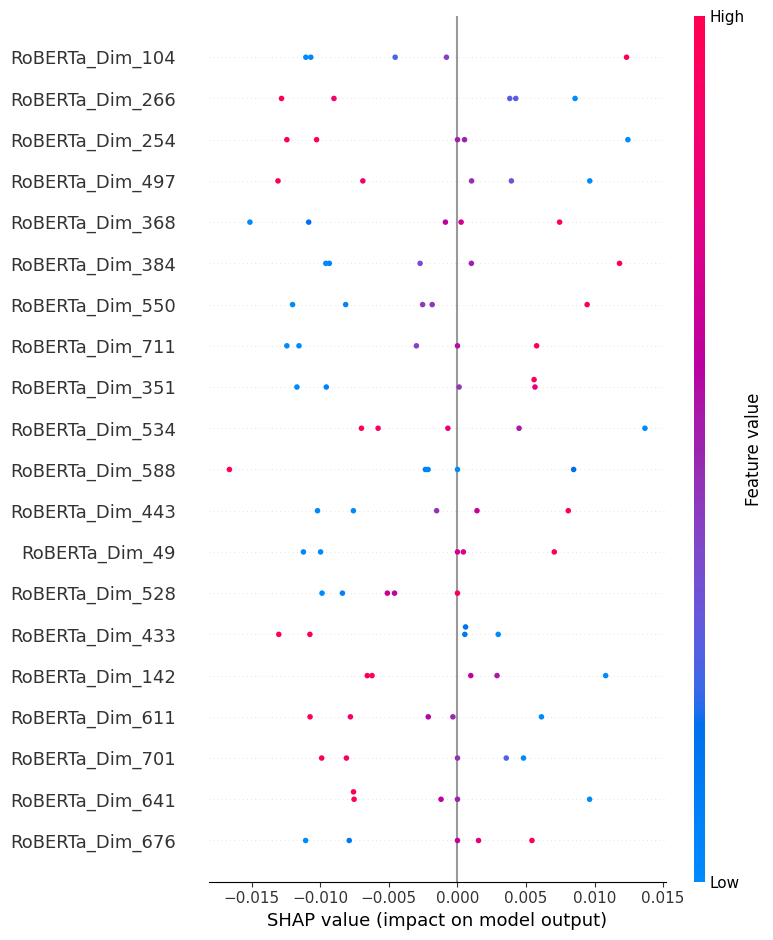

In [28]:
# --- SHAP Implementation (KernelExplainer with REDUCED SAMPLES for Memory) ---
import shap
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm

# Ensure the best model ('loaded_model_ro_lstm') and tokenizer ('tokenizer_roberta') are loaded.

# --- 1. Model Wrapper (Stays the same) ---
class ShapLSTMWrapper(nn.Module):
    def __init__(self, original_model):
        super(ShapLSTMWrapper, self).__init__()
        self.lstm = original_model.lstm
        self.dropout = original_model.dropout
        self.classifier = original_model.classifier
        self.bidirectional_lstm = original_model.bidirectional_lstm

    def forward(self, x):
        x_tensor = torch.from_numpy(x).float().to(device)
        sequence_input = x_tensor.unsqueeze(1)
        lstm_output, (hidden, cell) = self.lstm(sequence_input)
        if self.bidirectional_lstm:
            combined_hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            combined_hidden = hidden[-1,:,:]
        dropped_output = self.dropout(combined_hidden)
        logits = self.classifier(dropped_output)
        return logits.detach().cpu().numpy()

# --- 2. Instantiate the wrapper ---
shap_model = ShapLSTMWrapper(loaded_model_ro_lstm).to(device)
shap_model.eval()

# --- 3. Prepare the Data (Stays the same) ---
def get_cls_embeddings(df):
    loaded_model_ro_lstm.eval()
    roberta_embeddings = []
    with torch.no_grad():
        for text in tqdm(df['processed_text'], desc="Getting RoBERTa [CLS] Embeddings"):
            inputs = tokenizer_roberta(text, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN_ROBERTA).to(device)
            embedding = loaded_model_ro_lstm.roberta(**inputs).last_hidden_state[:, 0, :].cpu().numpy()
            roberta_embeddings.append(embedding)
    return np.vstack(roberta_embeddings)

# --- FIX: Drastically reduce the number of samples for the explainer ---
# This is the key change to manage memory usage.
print("Sampling a smaller subset of data for SHAP analysis to manage memory...")
df_test_sample = df_test_orig.sample(10, random_state=42)     # Background set: REDUCED from 100 to 10
df_explain_sample = df_test_orig.sample(5, random_state=0)  # Explanation set: REDUCED from 20 to 5

background_data_np = get_cls_embeddings(df_test_sample)
explain_data_np = get_cls_embeddings(df_explain_sample)
print(f"Background data shape: {background_data_np.shape}")
print(f"Explanation data shape: {explain_data_np.shape}")

# --- 4. Create the SHAP Explainer and get values ---
explainer = shap.KernelExplainer(shap_model, background_data_np)

print("\nCalculating SHAP values... (this may still take some time)")
shap_values = explainer.shap_values(explain_data_np)
print("SHAP values calculated.")

# --- 5. Visualize the results ---
feature_names = [f'RoBERTa_Dim_{i}' for i in range(768)]
print("\n--- Generating SHAP Global Feature Importance Plot ---")
shap.summary_plot(shap_values[1], features=explain_data_np, feature_names=feature_names, max_display=20)

**The Key High-Level Finding:**
The LSTM head has learned to identify specific semantic "concepts" within the RoBERTa sentence summary that are strong indicators of a tweet's origin. Unlike the statistical features (word count, etc.) which had zero impact, these embedding dimensions have a clear and consistent impact on the model's output.

**1. RoBERTa_Dim_104 and RoBERTa_Dim_550**
**Observation:** These are strong examples of features that push the prediction towards "human". For both, the blue dots (low feature value) are consistently on the left side of the zero line, indicating a negative SHAP value (impact towards "human").
**Interpretation:** While we don't know the exact meaning of "Dimension 104", we can infer its role. There is a "concept" captured by this dimension in RoBERTa's understanding of language. When this concept has a low value in a tweet's summary, the LSTM head becomes more confident that the tweet is human-written. This could correspond to concepts like informality, personal emotion, or lack of promotional language.


--- Starting Fine-Grained AI Model Detection Analysis for RoBERTa-LSTM ---


Making binary predictions:   0%|          | 0/160 [00:00<?, ?it/s]

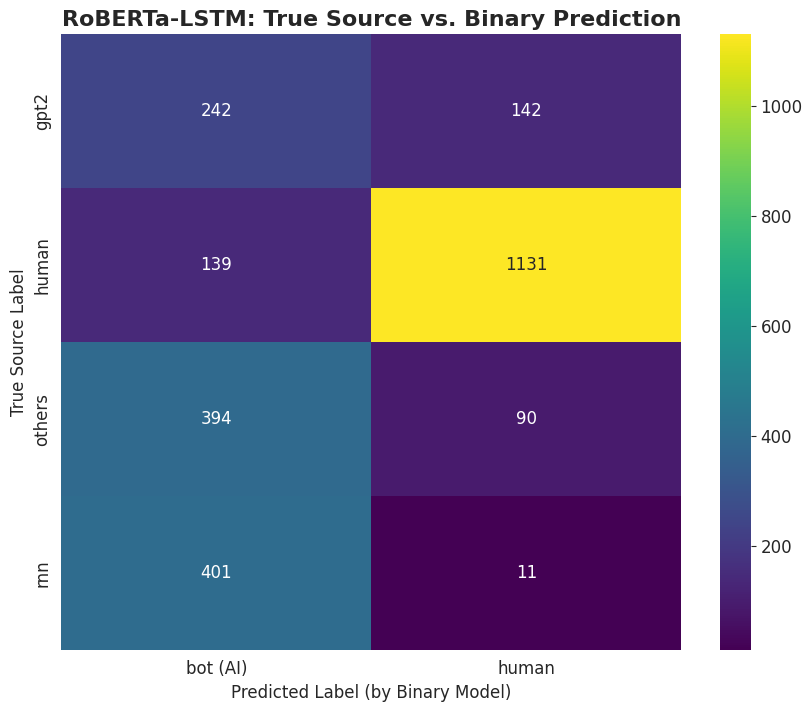

In [37]:
# --- SECTION: Multi-class Detection Analysis for RoBERTa-LSTM ---
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset

print("\n--- Starting Fine-Grained AI Model Detection Analysis for RoBERTa-LSTM ---")

# Use the df_test_orig which is already loaded
df_test_orig['ground_truth_source'] = df_test_orig['class_type'].fillna('human')

# We can reuse the test_encodings_hybrid from earlier in the notebook
pred_dataset_hybrid = TensorDataset(test_encodings_hybrid['input_ids'], test_encodings_hybrid['attention_mask'])
pred_dataloader_hybrid = DataLoader(pred_dataset_hybrid, batch_size=BATCH_SIZE)

all_binary_preds_ro_lstm = []
loaded_model_ro_lstm.eval()
with torch.no_grad():
    for batch in tqdm(pred_dataloader_hybrid, desc="Making binary predictions"):
        input_ids, attention_mask = [b.to(device) for b in batch]
        logits = loaded_model_ro_lstm(input_ids, attention_mask)["logits"]
        preds = torch.argmax(logits, dim=1)
        all_binary_preds_ro_lstm.extend(preds.cpu().numpy())

# Map binary predictions to labels
predicted_labels_ro_lstm = ['human' if p == 0 else 'bot (AI)' for p in all_binary_preds_ro_lstm]
cm_df_ro_lstm = pd.crosstab(df_test_orig['ground_truth_source'], pd.Series(predicted_labels_ro_lstm, name='Predicted'))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_ro_lstm, annot=True, fmt='d', cmap='viridis')
plt.title('RoBERTa-LSTM: True Source vs. Binary Prediction', fontsize=16, weight='bold')
plt.ylabel('True Source Label', fontsize=12)
plt.xlabel('Predicted Label (by Binary Model)', fontsize=12)
#plt.savefig(os.path.join(OUTPUT_DIR_HYBRID, "fig_ro_lstm_multiclass_cm.png"))
plt.show()